# Analysis of SEIRX model runs for test technology and screening frequency

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl

### Utility functions for plotting

In [2]:
def get_image(df, subset, metric):
    subset = df.loc[subset]
    img = np.zeros((4,4))
    screening_intervals = ['never', 'once\na week', 'twice\na week', '3 times\na week']
    for i, p_index in enumerate(screening_intervals):
        for j, e_index in enumerate(screening_intervals):
            img[i, j] = subset.loc[e_index, p_index][metric]
    return img

def plot_heatmap_turnover_time(ax, img, vmin, vmax, xticks, yticks):
    cmap = plt.get_cmap('coolwarm')
    im = ax.imshow(img, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
    
    if xticks:
        ax.set_xticks(range(len(screening_intervals)))
        ax.set_xticklabels(screening_intervals, fontsize=9)
        ax.set_xlabel('screening frequency employees', fontsize=12)
    else:
        ax.set_xticks([])
    if yticks:    
        ax.set_yticks(range(len(screening_intervals)))
        ax.set_yticklabels(screening_intervals, fontsize=9)
        ax.set_ylabel('screening frequency residents', fontsize=12)
    else:
        ax.set_yticks([])
    
    return im

def annotate_heatmap(ax, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y_pos = i - 0.05
            x_pos = j - 0.15
            ax.text(x_pos, y_pos, '{:1.2f}'.format(img[i, j]))

### Mappings of variables to nicer labels for plots

In [3]:
frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

test_name_map = {'same_day_antigen':'same-day antigen', 'one_day_PCR':'one day PCR',
             'two_day_PCR':'two days PCR', 'same_day_PCR':'same-day PCR',
             'same_day_LAMP':'same-day RT-LAMP'}

metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                   'infected_residents_median':'follow-up cases residends (median)',
                   'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                   'R0_mean':'$R_0$',
                   'R0_mean':'$R_0$'}

index_case_map = {'employee':'index case employee',
                  'resident':'index case resident'}

screening_intervals = ['never', 'once\na week', 'twice\na week', '3 times\na week']

### Data loading and wrangling

In [4]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 10000
data = pd.read_csv(join(res_path,'{}_{}.csv'.format(sim_name, N_runs)))

In [5]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

## Different test technologies

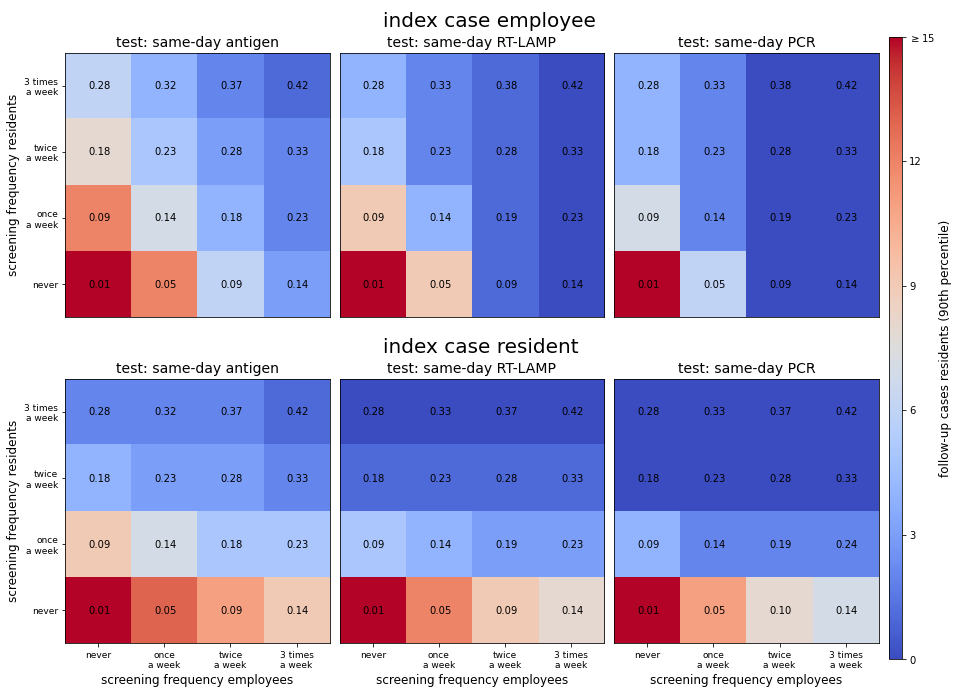

In [6]:
metric = 'infected_residents_0.90'
sim_name = 'simulation_results'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=15
vstep=3

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = get_image(df, test_type, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = plot_heatmap_turnover_time(ax,img,vmin,vmax,xticks,yticks)
        
        # annotate heatmap with tests / days / agent
        tests_per_agent = get_image(df, test_type, 'N_tests_mean') / (35+18)
        duration = get_image(df,test_type, 'duration_mean')
        tests_per_agent_per_day = tests_per_agent / duration
        annotate_heatmap(ax, tests_per_agent_per_day)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_test_technology.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_test_technology.pdf'))

## PCR: different turnover times

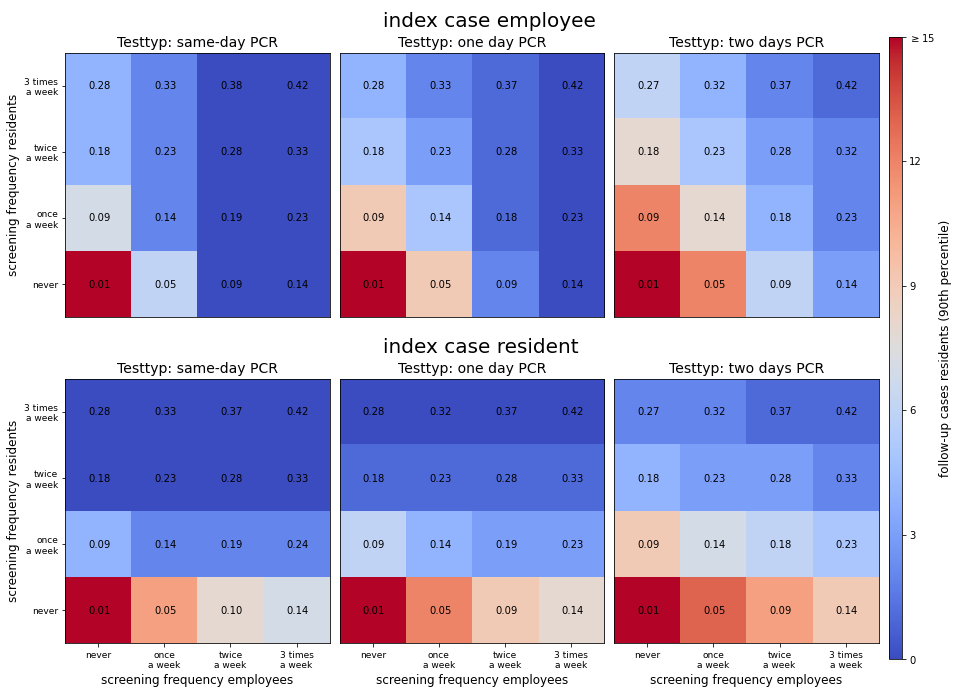

In [7]:
metric = 'infected_residents_0.90'
sim_name = 'simulation:results'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 15
vstep = 3

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Testtyp: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = get_image(df, test_type, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = plot_heatmap_turnover_time(ax, img, vmin, vmax, xticks, yticks)
        
        # annotate heatmap with tests / days / agent
        tests_per_agent = get_image(df, test_type, 'N_tests_mean') / (35+18)
        duration = get_image(df,test_type, 'duration_mean')
        tests_per_agent_per_day = tests_per_agent / duration
        annotate_heatmap(ax, tests_per_agent_per_day)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.pdf'))

## Number of agents infected by the index case

In [8]:
# all ensembles that had no preventive testing in place (the test technology
# does not make a difference, because it is only used for potential preventive
# tests anyways)
no_measures = data.loc[:,'never', 'never'].copy().reset_index()
nm_residents = no_measures[no_measures['index_case'] == 'resident']
nm_employees = no_measures[no_measures['index_case'] == 'employee']

In [9]:
print('index case resident: R = {:1.4f} +- {:1.4f}'\
      .format(nm_residents['R0_mean'].mean(), nm_residents['R0_std'].mean()))
print('index case employee: R = {:1.4f} +- {:1.4f}'\
      .format(nm_employees['R0_mean'].mean(), nm_employees['R0_std'].mean()))

index case resident: R = 1.3569 +- 1.4948
index case employee: R = 1.2618 +- 1.4217


## Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

In [10]:
nm_residents['infected_residents_0.10'] - 1

1    0.0
3    0.0
5    0.0
7    0.0
9    0.0
Name: infected_residents_0.10, dtype: float64

In [11]:
nm_residents['infected_residents_median'] - 1

1    1.0
3    1.0
5    1.0
7    1.0
9    1.0
Name: infected_residents_median, dtype: float64

In [12]:
nm_residents['infected_residents_0.90'] - 1

1    17.0
3    16.0
5    17.0
7    17.0
9    16.1
Name: infected_residents_0.90, dtype: float64

In [13]:
nm_employees['infected_residents_0.10']

0    0.0
2    0.0
4    0.0
6    0.0
8    0.0
Name: infected_residents_0.10, dtype: float64

In [14]:
nm_employees['infected_residents_median']

0    1.0
2    1.0
4    1.0
6    1.0
8    1.0
Name: infected_residents_median, dtype: float64

In [15]:
nm_employees['infected_residents_0.90']

0    17.0
2    17.0
4    17.0
6    17.0
8    17.0
Name: infected_residents_0.90, dtype: float64

## Results table

In [30]:
table_data = data.loc[:,:,:,'employee']

In [31]:
table_cols = ['infected_residents_mean', 'infected_residents_std',
              'infected_residents_median', 'infected_residents_0.10',
              'infected_residents_0.90', 'R0_mean', 'R0_std', 'test_rate_mean', 'test_rate_std']
table_data = table_data.loc[:, :, ['never', 'once\na week']][table_cols]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])
table_data.to_csv(join(res_path, 'table_testing_strategy.csv'))

## Diagnostic testing base rate

In [48]:
data['test_rate_mean'][0:128].min()

0.0037916829145176

In [49]:
data['test_rate_mean'].idxmin()

('same_day_LAMP', 'never', 'never', 'resident')

In [50]:
data.loc[data['test_rate_mean'].idxmin()]['test_rate_std']

0.0031293917327488

## Preventive testing rates

In [53]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141023       0.011091
                 resident          0.143389       0.010442
same_day_LAMP    employee          0.141481       0.011839
                 resident          0.143674       0.010324
same_day_PCR     employee          0.141198       0.012123
                 resident          0.143444       0.010306
one_day_PCR      employee          0.140948       0.011740
                 resident          0.143315       0.010637
two_day_PCR      employee          0.140032       0.011694
                 resident          0.142385       0.011165

In [54]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.278528       0.019056
                 resident          0.277601       0.021390
same_day_LAMP    employee          0.279393       0.019211
                 resident          0.278449       0.023047
same_day_PCR     employee          0.279292       0.018937
                 resident          0.277911       0.023607
one_day_PCR      employee          0.278382       0.019262
                 resident          0.277612       0.023172
two_day_PCR      employee          0.277170       0.020358
                 resident          0.275981       0.021970

In [56]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.422870       0.032640
                 resident          0.422355       0.032381
same_day_LAMP    employee          0.424469       0.035864
                 resident          0.423548       0.034581
same_day_PCR     employee          0.423645       0.036273
                 resident          0.423324       0.036056
one_day_PCR      employee          0.422613       0.035331
                 resident          0.423618       0.035162
two_day_PCR      employee          0.422195       0.033440
                 resident          0.421534       0.033344